# Lab | Unsupervised learning intro
### Instructions
It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

1. Check whether or not the song is in the Billboard Hot 200.

2. Collect the audio features from the Spotify API.

After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.



# Import Libraries

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import pandas as pd
import time 

from dotenv import load_dotenv
import os

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-info">
<h1>Part I : Preparing Data</h1>
</div>

# Load Data
- This dataset is the audio feature from the previous lab

In [2]:
df = pd.concat(map(pd.read_csv, ['audio_features_249.csv', 
                                 'audio_features_viralhits_200.csv',
                                 'audio_features_viralhits_75.csv']))
df.reset_index(drop=True)
print("Total songs: ", len(df))
df.head(3)

Total songs:  524


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,title,artist_id,artist_name
0,0.550,0.750,0,-3.289,1,0.1460,0.0561,0.000000,0.1290,0.381,...,audio_features,5JVA0t7r2Y7m9NaHmgaeiC,spotify:track:5JVA0t7r2Y7m9NaHmgaeiC,https://api.spotify.com/v1/tracks/5JVA0t7r2Y7m...,https://api.spotify.com/v1/audio-analysis/5JVA...,147410,4,Remedy,2NpPlwwDVYR5dIj0F31EcC,Leony
1,0.714,0.425,1,-8.064,1,0.0809,0.4030,0.000105,0.1150,0.316,...,audio_features,0RSZ8EmUPEN3ySfCgytPke,spotify:track:0RSZ8EmUPEN3ySfCgytPke,https://api.spotify.com/v1/tracks/0RSZ8EmUPEN3...,https://api.spotify.com/v1/audio-analysis/0RSZ...,165477,4,Auf & Ab,5ZY4M2aGiTaZQEP6HfqeJc,Montez
2,0.761,0.525,11,-6.900,1,0.0944,0.4400,0.000007,0.0921,0.531,...,audio_features,6CDzDgIUqeDY5g8ujExx2f,spotify:track:6CDzDgIUqeDY5g8ujExx2f,https://api.spotify.com/v1/tracks/6CDzDgIUqeDY...,https://api.spotify.com/v1/audio-analysis/6CDz...,238805,4,Heat Waves,4yvcSjfu4PC0CYQyLy4wSq,Glass Animals


# Get more tracks from playlists

- We have retrieved 524 audio features from the previous lab
- Since we want to cluster songs for recommendation, I prefer to get a few more. So I listed 3 playlist from spotify
- In this section, we'll retrieve 150 more songs from 3 playlists

## Set up spotify credentials

In [3]:
# Get dotenv environment
load_dotenv() # We'll get environment variables in the .env file to use when called 

client_id = os.getenv("client_id")
client_secret = os.getenv("client_secret")

# Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

## Create functions to get audio features from playlists

In [4]:
def get_audio_features(playlist_id):
    
    """
    This function returns audio features from the given a playlist_id on spotify
    """
    # Get 50 tracks from playlist
    playlist = sp.user_playlist_tracks("spotify", playlist_id)
    
    # Extract track_id, title, artist_id, artist_name
    track_ids = [playlist['items'][i]['track']['id'] for i in range(playlist['total'])]
    title = [playlist['items'][i]['track']['name'] for i in range(playlist['total'])]
    
    artist_id = [playlist['items'][i]['track']['artists'][0]['id'] for i in range(playlist['total'])]
    artist_name = [playlist['items'][i]['track']['artists'][0]['name'] for i in range(playlist['total'])]
    
    # extract the audio features
    audio_features = sp.audio_features(track_ids)
    
    # store audio features in a dataframe
    df = pd.DataFrame(audio_features)
    df['title'] = title
    df['artist_id'] = artist_id
    df['artist_name'] = artist_name
    
    return df

In [5]:
def audio_features_multiple_playlist_to_df(playlist_id_list):
    """
    In case you have multiple playlist,
    this function takes an argument of a list of playlist_id &
    return audio features dataframe
    """
    
    df_results = []
    df_result = pd.DataFrame()
    
    for playlist_id in playlist_id_list:
        playlist_id = get_audio_features(playlist_id)
        # df_result = pd.concat([df_result, playlist_id])
        df_results.append(playlist_id)
        time.sleep(10)
    
    for result in df_results:
        df_result = df_result.append(result)
        
    return df_result

## Set up a list of spotify playlists

In [6]:
# Set up multiple playlists that we will retrieve the data
viral50 = "37i9dQZEVXbLiRSasKsNU9"
top50_daily = "37i9dQZEVXbMDoHDwVN2tF"
top50_weekly = "37i9dQZEVXbNG2KDcFcKOF"

playlist_list = [viral50, top50_daily, top50_weekly]

## Calling function to get audio features from the multiple playlists

In [7]:
# Calling the function & get a dataframe of audio features
df_result = audio_features_multiple_playlist_to_df(playlist_list)

In [8]:
# Check dataframe
print(f"We retrieved {len(df_result)} songs & audio features from the playlists")
df_result.head()

We retrieved 150 songs & audio features from the playlists


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,title,artist_id,artist_name
0,0.707,0.835,8,-8.759,0,0.0418,0.6010,0.791000,0.0933,0.0958,...,audio_features,199wv1uOJYZ1XyK8FTzwh2,spotify:track:199wv1uOJYZ1XyK8FTzwh2,https://api.spotify.com/v1/tracks/199wv1uOJYZ1...,https://api.spotify.com/v1/audio-analysis/199w...,200156,4,Ascend,4FAahCBNlbpgoAhVfuUHPD,Dezko
1,0.759,0.485,2,-8.050,0,0.1660,0.1040,0.000000,0.1090,0.4060,...,audio_features,32YA3PItSKjcNONrp1p4Y5,spotify:track:32YA3PItSKjcNONrp1p4Y5,https://api.spotify.com/v1/tracks/32YA3PItSKjc...,https://api.spotify.com/v1/audio-analysis/32YA...,133730,4,MAMTA'S INTERLUDE,01Co4R2CqEEwVgmbNMPei4,Gauntlet.
2,0.529,0.469,1,-6.967,0,0.0358,0.0899,0.000015,0.8310,0.3440,...,audio_features,0eFMbKCRw8KByXyWBw8WO7,spotify:track:0eFMbKCRw8KByXyWBw8WO7,https://api.spotify.com/v1/tracks/0eFMbKCRw8KB...,https://api.spotify.com/v1/audio-analysis/0eFM...,239906,4,Still With You,6HaGTQPmzraVmaVxvz6EUc,Jung Kook
3,0.812,0.557,6,-6.577,0,0.0623,0.1810,0.000118,0.1640,0.5770,...,audio_features,7rRpt0FcGdDxyhiFcSlswH,spotify:track:7rRpt0FcGdDxyhiFcSlswH,https://api.spotify.com/v1/tracks/7rRpt0FcGdDx...,https://api.spotify.com/v1/audio-analysis/7rRp...,187973,4,Maria Hiwaga,52D0Fi29GcObaFnweqsV6d,Sassa Gurl
4,0.881,0.830,4,-2.987,0,0.1580,0.1210,0.000000,0.0781,0.5040,...,audio_features,5YXLjznHYr6US2UN54AjRD,spotify:track:5YXLjznHYr6US2UN54AjRD,https://api.spotify.com/v1/tracks/5YXLjznHYr6U...,https://api.spotify.com/v1/audio-analysis/5YXL...,119362,4,One Margarita (Margarita Song),3qhkjSaDQrlZVAg0hvVYfh,That Chick Angel


## Include all data into one df

In [9]:
# Concat the dataset we have got from the previous lab together
df = pd.concat([df, df_result]).reset_index(drop=True)

In [10]:
# Check df
print(len(df))
df.head()

674


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,title,artist_id,artist_name
0,0.550,0.750,0,-3.289,1,0.1460,0.05610,0.000000,0.1290,0.381,...,audio_features,5JVA0t7r2Y7m9NaHmgaeiC,spotify:track:5JVA0t7r2Y7m9NaHmgaeiC,https://api.spotify.com/v1/tracks/5JVA0t7r2Y7m...,https://api.spotify.com/v1/audio-analysis/5JVA...,147410,4,Remedy,2NpPlwwDVYR5dIj0F31EcC,Leony
1,0.714,0.425,1,-8.064,1,0.0809,0.40300,0.000105,0.1150,0.316,...,audio_features,0RSZ8EmUPEN3ySfCgytPke,spotify:track:0RSZ8EmUPEN3ySfCgytPke,https://api.spotify.com/v1/tracks/0RSZ8EmUPEN3...,https://api.spotify.com/v1/audio-analysis/0RSZ...,165477,4,Auf & Ab,5ZY4M2aGiTaZQEP6HfqeJc,Montez
2,0.761,0.525,11,-6.900,1,0.0944,0.44000,0.000007,0.0921,0.531,...,audio_features,6CDzDgIUqeDY5g8ujExx2f,spotify:track:6CDzDgIUqeDY5g8ujExx2f,https://api.spotify.com/v1/tracks/6CDzDgIUqeDY...,https://api.spotify.com/v1/audio-analysis/6CDz...,238805,4,Heat Waves,4yvcSjfu4PC0CYQyLy4wSq,Glass Animals
3,0.774,0.792,10,-4.021,1,0.0523,0.05100,0.000000,0.1550,0.507,...,audio_features,3eJH2nAjvNXdmPfBkALiPZ,spotify:track:3eJH2nAjvNXdmPfBkALiPZ,https://api.spotify.com/v1/tracks/3eJH2nAjvNXd...,https://api.spotify.com/v1/audio-analysis/3eJH...,139672,4,Acapulco,07YZf4WDAMNwqr4jfgOZ8y,Jason Derulo
4,0.762,0.766,7,-3.955,1,0.0343,0.00776,0.000070,0.1280,0.442,...,audio_features,5fwSHlTEWpluwOM0Sxnh5k,spotify:track:5fwSHlTEWpluwOM0Sxnh5k,https://api.spotify.com/v1/tracks/5fwSHlTEWplu...,https://api.spotify.com/v1/audio-analysis/5fwS...,287120,4,Pepas,329e4yvIujISKGKz1BZZbO,Farruko


In [11]:
# Check number of duplicated
df.duplicated().sum()

115

In [12]:
# Do a quick check on the song that duplicate
# df[df.duplicated()]
df[df['id'].str.contains('6tAKikIvnoWfUeZrfkopLL')] # pick one random duplicated song to see how it duplicates

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,title,artist_id,artist_name
220,0.79,0.979,11,-4.637,0,0.117,0.0177,0.000192,0.237,0.898,...,audio_features,6tAKikIvnoWfUeZrfkopLL,spotify:track:6tAKikIvnoWfUeZrfkopLL,https://api.spotify.com/v1/tracks/6tAKikIvnoWf...,https://api.spotify.com/v1/audio-analysis/6tAK...,146087,4,Friesenjung,6CP5wWvO8oIxedESJNCN4H,Ski Aggu
572,0.79,0.979,11,-4.637,0,0.117,0.0177,0.000192,0.237,0.898,...,audio_features,6tAKikIvnoWfUeZrfkopLL,spotify:track:6tAKikIvnoWfUeZrfkopLL,https://api.spotify.com/v1/tracks/6tAKikIvnoWf...,https://api.spotify.com/v1/audio-analysis/6tAK...,146087,4,Friesenjung,6CP5wWvO8oIxedESJNCN4H,Ski Aggu


In [13]:
# Drop duplicated rows
df = df.drop_duplicates().reset_index(drop=True)
print(f"We have total {len(df)} songs with audio_features for clustering")

We have total 559 songs with audio_features for clustering


<div class="alert alert-block alert-info">
<h1>Part II : Clustering the songs: Unsupervised Learning</h1>
</div>

In [14]:
# Import Libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from matplotlib import pyplot as plt

# Select the features needed for clustering

In [15]:
# Get list of column names & copy them to create a feature list
df.columns.tolist()

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url',
 'duration_ms',
 'time_signature',
 'title',
 'artist_id',
 'artist_name']

In [16]:
# Now we have 11 features from the df as an X datafram
X = df[['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']]

In [17]:
# Check data
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.550,0.750,0,-3.289,1,0.1460,0.05610,0.000000,0.1290,0.381,172.124
1,0.714,0.425,1,-8.064,1,0.0809,0.40300,0.000105,0.1150,0.316,99.034
2,0.761,0.525,11,-6.900,1,0.0944,0.44000,0.000007,0.0921,0.531,80.870
3,0.774,0.792,10,-4.021,1,0.0523,0.05100,0.000000,0.1550,0.507,122.062
4,0.762,0.766,7,-3.955,1,0.0343,0.00776,0.000070,0.1280,0.442,130.001


In [18]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,-0.977787,0.368517,-1.412278,1.399544,0.886534,0.462824,-0.696293,-0.227827,-0.453387,-0.553209,1.722783
1,0.285739,-1.614844,-1.143387,-0.820908,0.886534,-0.248731,0.880411,-0.226937,-0.557559,-0.839891,-1.107512
2,0.647847,-1.004579,1.545521,-0.279630,0.886534,-0.101174,1.048581,-0.227770,-0.727955,0.108363,-1.810885
3,0.748005,0.624828,1.276630,1.059152,0.886534,-0.561335,-0.719473,-0.227827,-0.259924,0.002511,-0.215789
4,0.655552,0.466159,0.469958,1.089843,0.886534,-0.758078,-0.916005,-0.227235,-0.460828,-0.284170,0.091636


# Find optimal number of clusters in K-means clustering

Two popular methods we are going to apply in order to find optimal n_clusters:
1. Silhouette analysis
2. Elbow analysis

## 1. Silhouette Analysis

In [19]:
def silhouette_check(df, n_cluster_range):
    """
    This function gives silhouette score from the kmeans model,
    helps to find out the best number of the cluster to apply in the model
    """
    for n in n_cluster_range:
        km = KMeans(n_clusters=n, random_state=42)
        km.fit(df)
        clusters = km.predict(df)
        score = round(silhouette_score(df, km.labels_, metric='euclidean'), 4)
        print(f"silhouette_score for {n} clusters", score)

In [20]:
# Testing clustering from 2 - 15 clusters
n_cluster = range(2, 16)

silhouette_check(X_scaled, n_cluster)

silhouette_score for 2 clusters 0.1515
silhouette_score for 3 clusters 0.1612
silhouette_score for 4 clusters 0.122
silhouette_score for 5 clusters 0.1313
silhouette_score for 6 clusters 0.1237
silhouette_score for 7 clusters 0.1282
silhouette_score for 8 clusters 0.1194
silhouette_score for 9 clusters 0.1204
silhouette_score for 10 clusters 0.1228
silhouette_score for 11 clusters 0.1149
silhouette_score for 12 clusters 0.1238
silhouette_score for 13 clusters 0.1208
silhouette_score for 14 clusters 0.1164
silhouette_score for 15 clusters 0.1145


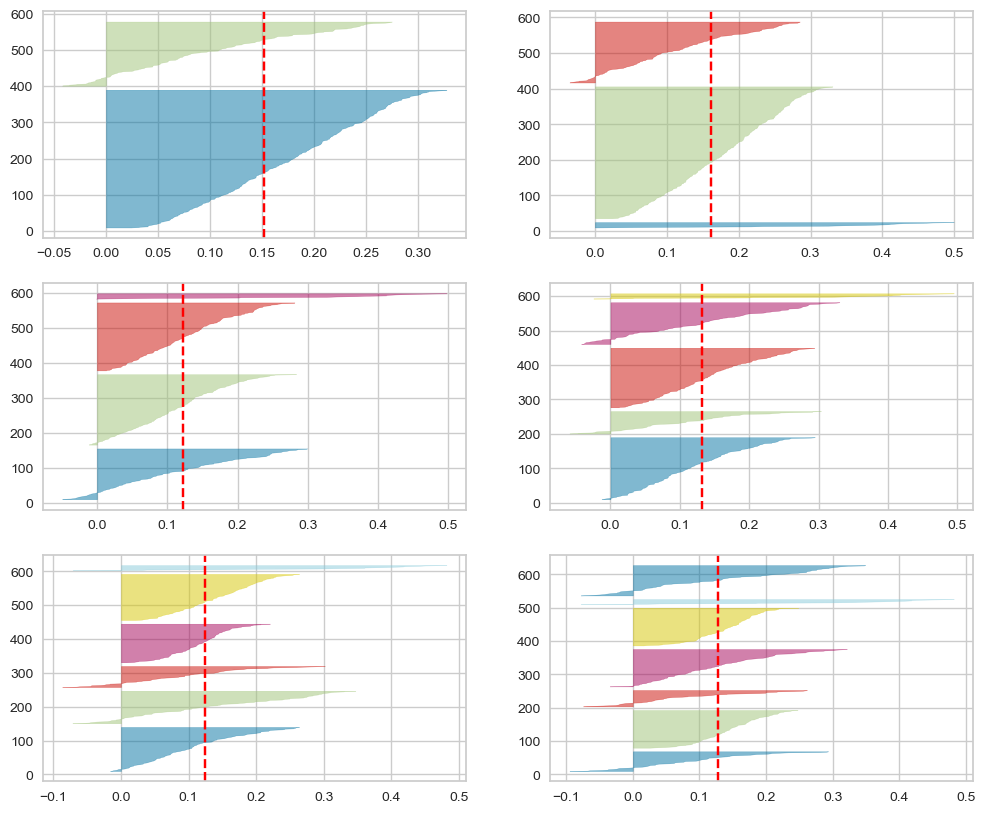

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10))
for i in range(2, 8):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled)

### What do we get from Silhouette plot?
- The overall silhouette score is low but from the range of K number 2-15, K number = 3 gives the best silhouette score hence K = 3 is the optimal n_cluster
- From the silhouette plot, K = 4 is quite nice for the human eyes because all clusters are beyond average Silhouette score. And the thickness is almost uniform among clusters. K=2 provided (almost) uniform thickness as well.

#### Next?
- We can also check with Elbow score if they are consistent

## 2. Elbow Method

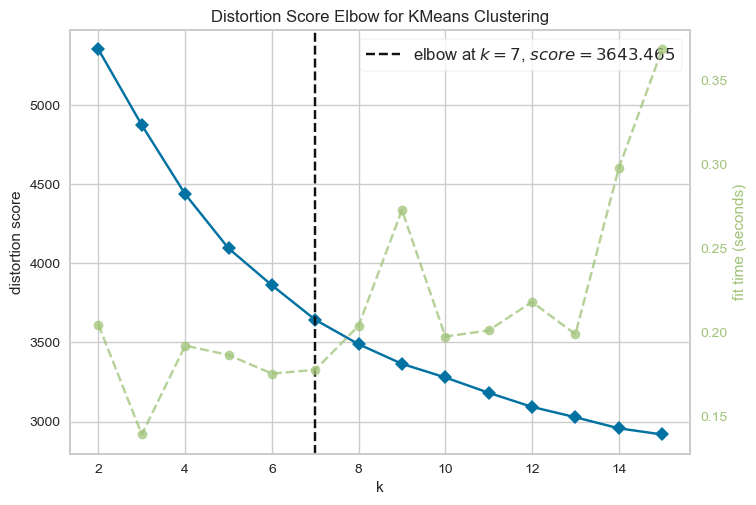

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
visualizer = KElbowVisualizer(km, k=(2, 16))

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.poof()           # Draw/show/poof the data

### What do we get from the Elbow plot?
- Elbow method showed K = 7 is the point where the SSE plot starts looking linear. From the given result, k = 7 is the optimal point for the K number
- But for human eyes, I would choose 4 or 5 as the optimal points. 
- K = 3 also looked like an elbow plus the fit time is the lowest. Therefor, this could be optimal K for applying the model as it performs the fastest and has the highest Silhouette score.


Note: But I like K=4. :p

### Reference:
- [Elbow Method vs Silhouette Score – Which is Better?](https://vitalflux.com/elbow-method-silhouette-score-which-better/)
- [Stop using the Elbow Method](https://medium.com/geekculture/stop-using-the-elbow-method-96bcfbbbe9fd)

# Apply the K-means clustering with optimal K (number of clusters)

- From previous step, K=3 seems to be the optimal number of clusters.
- Therefore, we'll apply to the KMeans clustering to cluster our songs into 3 groups

In [23]:
# Clustering songs using Kmeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

In [24]:
#create new dataframe with title, artist and cluster assigned
df_clustered = pd.DataFrame(X_scaled)
df_clustered['song_name'] = df['title']
df_clustered['artist'] = df['artist_name']
df_clustered['cluster'] = clusters
df_clustered.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_name,artist,cluster
0,-0.977787,0.368517,-1.412278,1.399544,0.886534,0.462824,-0.696293,-0.227827,-0.453387,-0.553209,1.722783,Remedy,Leony,1
1,0.285739,-1.614844,-1.143387,-0.820908,0.886534,-0.248731,0.880411,-0.226937,-0.557559,-0.839891,-1.107512,Auf & Ab,Montez,2
2,0.647847,-1.004579,1.545521,-0.279630,0.886534,-0.101174,1.048581,-0.227770,-0.727955,0.108363,-1.810885,Heat Waves,Glass Animals,2
3,0.748005,0.624828,1.276630,1.059152,0.886534,-0.561335,-0.719473,-0.227827,-0.259924,0.002511,-0.215789,Acapulco,Jason Derulo,1
4,0.655552,0.466159,0.469958,1.089843,0.886534,-0.758078,-0.916005,-0.227235,-0.460828,-0.284170,0.091636,Pepas,Farruko,1


In [25]:
len(df_clustered)

559

In [26]:
# Check out a song_name 'Maria'
df_clustered[df_clustered['song_name'].str.contains('Maria')]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_name,artist,cluster
444,0.771118,-0.540778,-0.874496,0.170971,0.886534,0.244220,-0.766743,-0.210792,-1.154316,0.765525,-1.150999,Maria Maria (feat. The Product G&B),Santana,1
485,1.040773,-0.809294,0.201067,-0.129429,-1.127988,-0.452033,-0.128607,-0.226827,-0.192957,0.311245,0.591942,Maria Hiwaga,Sassa Gurl,1


In [27]:
# Check out cluster == 2
df_clustered[df_clustered.cluster==2]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,song_name,artist,cluster
1,0.285739,-1.614844,-1.143387,-0.820908,0.886534,-0.248731,0.880411,-0.226937,-0.557559,-0.839891,-1.107512,Auf & Ab,Montez,2
2,0.647847,-1.004579,1.545521,-0.279630,0.886534,-0.101174,1.048581,-0.227770,-0.727955,0.108363,-1.810885,Heat Waves,Glass Animals,2
5,0.694074,-1.273096,-1.412278,-1.032956,-1.127988,-0.255289,0.112285,-0.227827,0.588334,1.122774,0.869009,Savage Love (Laxed - Siren Beat),Jawsh 685,2
9,0.609325,-1.590433,-0.067824,-0.827884,-1.127988,-0.810543,-0.905369,-0.222835,-0.274806,-1.827839,-1.263413,APOLOGIZE,Baby Keem,2
11,-0.045551,-0.327185,0.201067,-0.845554,-1.127988,-0.007174,1.389466,-0.224344,-0.133430,-1.078057,-0.258230,Where Are You Now,Lost Frequencies,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,0.385897,-0.430930,1.276630,-1.811858,-1.127988,0.331662,0.316816,-0.227734,-0.460828,-0.266528,-1.147940,Pişman Değilim,Semicenk,2
526,-1.116467,-1.596536,-1.412278,-0.444710,0.886534,-0.857543,0.371357,-0.225852,-0.690006,-0.451768,-1.657772,Nanti Kita Seperti Ini,Batas Senja,2
538,-1.640368,-1.663665,-1.412278,-1.416594,-1.127988,-0.853170,-0.333138,-0.041378,-0.688518,-0.120982,-2.327533,I Wanna Be Yours,Arctic Monkeys,2
551,1.572379,-0.595702,-0.874496,0.651333,0.886534,-0.778845,1.862159,-0.227715,-0.742837,0.937534,-1.029136,Left and Right (Feat. Jung Kook of BTS),Charlie Puth,2


# Create a function for song recommendation

- First, we check if the given song is on the Billboard Hot 100 
- If it is a hot song, we'll recommend a random song on the Billboard Hot 100 list
- If the song is not in the list, we'll recommend another song that is similar to the user's favorite (predictiong from the audio feature)

In [28]:
# Get dataframe from billboard hot 100 list
df_bb100 = pd.read_csv("billboard_hot100.csv")

In [29]:
def recommend_song():
    
    """
    This function will recommend a song for the user.
    If it's on Billboard hot 100, you'll get a random song on the Billboard,
    if not, you'll get a song in the same cluster from spotify 
    """
    
    input_h = input("Pick your favorite song: ")
    
    # Try random song on billboard hot 100
    try: 
        if df_bb100['Song'].str.contains(input_h, case=False).any():
            rec = df_bb100.sample(1)
            song_title = rec['Song'].tolist()[0]
            artist = rec['Artist'].tolist()[0]
            print("[RECOMMEND SONG]")
            return ' - '.join([song_title, artist])
    except:
        return input_h
    
    # If not on the Billboard, find similar taste on spotify
    else:
        # get song id from user
        song_name = input_h
        results = sp.search(q=f'track:{song_name}', limit=1)
        track_id = results['tracks']['items'][0]['id']

        # get song features with the obtained id
        audio_features = sp.audio_features(track_id)

        # converting it into a dataframe
        df_ = pd.DataFrame(audio_features)
        new_features = df_[X.columns]

        # scaling the audio features
        scaled_x = scaler.transform(new_features)

        # assign the cluster to the given song
        cluster = kmeans.predict(scaled_x)

        # take another close song in the same cluster to recommend
        filtered_df = df_clustered[df_clustered['cluster'] == cluster[0]][X.columns]
        closest, _ = pairwise_distances_argmin_min(scaled_x, filtered_df)

        # return it in a readable way
        print('\n [RECOMMENDED SONG]')
        return ' - '.join([df_clustered.loc[closest]['song_name'].values[0], df_clustered.loc[closest]['artist'].values[0]])



In [30]:
# Calling function 
recommend_song()

Pick your favorite song: Run boy run

 [RECOMMENDED SONG]


'Someone Else - ClockClock'

# Result & Discussion

I choose a song that's not on the Billboard: "Run boy run". From different n_cluster, here are the results:

    - K=3 --> recommend: Someone Else - ClockClock >> this song sounds the most similar to the input
    - K=4 --> recommend: Dancing - Ray-X >> too much fun, more like dancing
    - K=5 --> recommend: Auf gute Freunde - Böhse Onkelz
    - K=6 --> recommend: Where Are You Now - Lost Frequencies >> close but it's a bit happier than the input song
    - K=7 --> recommend: APOLOGIZE - Baby Keem >> too hip-hop, not close to the input
    